<a href="https://colab.research.google.com/github/ArunDharavath/ML-DL/blob/main/NLP/NLP_Beginner_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import spacy
from spacy.util import compounding, minibatch

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

In [3]:
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spam.csv', encoding='latin-1')

df = df.dropna(how='any', axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['msg_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,msg_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [6]:
#each class count

balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

<BarContainer object of 2 artists>

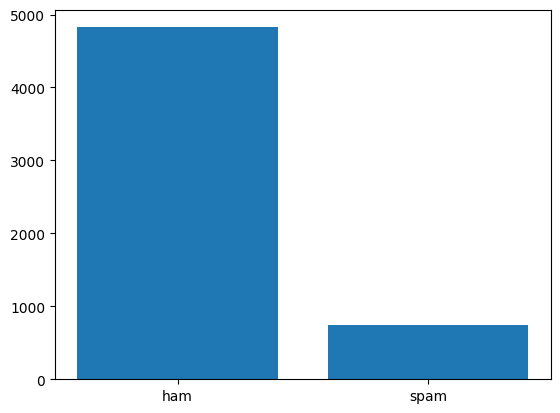

In [7]:
plt.bar(df['target'].unique(), list(df['target'].value_counts()))

Text(0.5, 0, 'Message length')

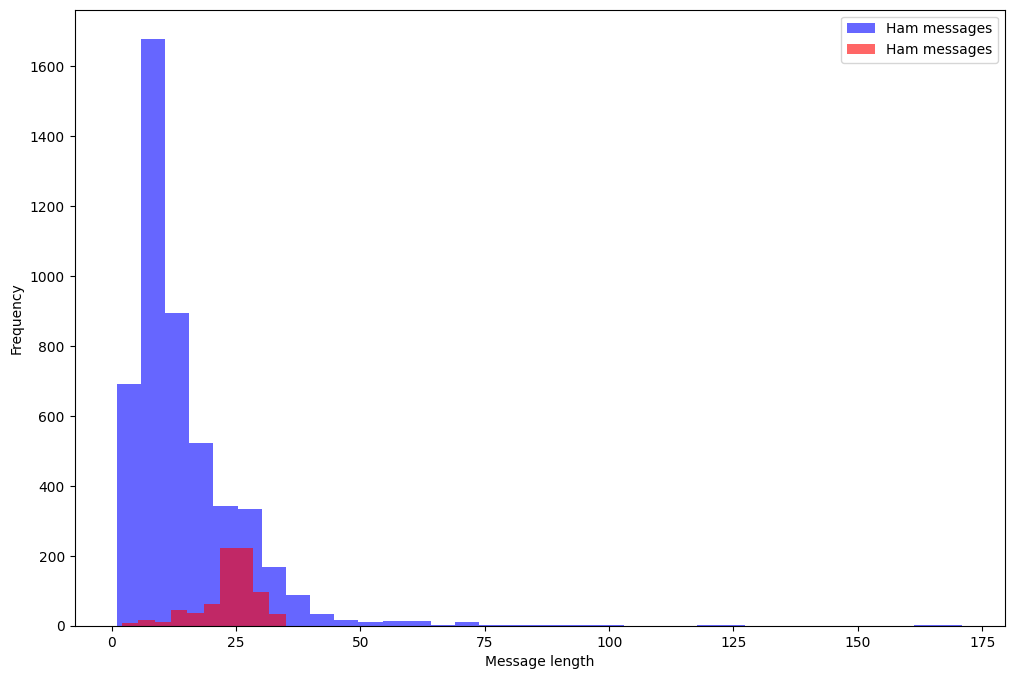

In [8]:
#plotting the distribution of frequency vs message length
plt.figure(figsize=(12, 8))

df[df.target == 'ham'].msg_len.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
df[df.target == 'spam'].msg_len.plot(kind='hist', color='red', label='Ham messages', alpha=0.6)

plt.legend()
plt.xlabel('Message length')

The above shows that a majority of "ham" messages have low lengths compared to that of "spam" messages.

In [9]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [10]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,msg_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,msg_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


In [13]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [14]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,msg_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,msg_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


In [16]:
from sklearn.model_selection import train_test_split

X = df['message_clean']
y = df['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4179 4179
1393 1393


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [18]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [19]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<4179x5717 sparse matrix of type '<class 'numpy.float64'>'
	with 32431 stored elements in Compressed Sparse Row format>

In [21]:
texts = df['message_clean']
target = df['target_encoded']

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6769

In [22]:
import nltk
nltk.download('punkt')

def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


array([[   2, 3199,  276, ...,    0,    0,    0],
       [   8,  239,  532, ...,    0,    0,    0],
       [   9,  361,  591, ...,    0,    0,    0],
       ...,
       [6767, 1007, 6768, ...,    0,    0,    0],
       [ 139, 1257, 1612, ...,    0,    0,    0],
       [1998,  382,  171, ...,    0,    0,    0]], dtype=int32)

In [23]:
embeddings_dictionary = dict()
embedding_dim = 100

with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [24]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# **Naive Bayes**

In [25]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [26]:
y_pred = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [27]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
print()
metrics.confusion_matrix(y_test, y_pred)

0.9784637473079684



array([[1191,   11],
       [  19,  172]])

In [28]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9745842444094048

# **XGBoost**

In [29]:
import xgboost as xgb
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc'
    ))
])

In [30]:
pipe.fit(X_train, y_train)

y_pred_test = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_test)))

metrics.confusion_matrix(y_test, y_pred_test)

Train: 0.9830102895429529
Test: 0.964824120603015


array([[1197,    5],
       [  44,  147]])

# **LSTM**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [32]:
def glove_lstm():
  model = Sequential()

  model.add(Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=embedding_matrix.shape[1],
                      weights=[embedding_matrix],
                      input_length=length_long_sentence
                      ))

  model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
        )))

  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(length_long_sentence, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(length_long_sentence, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

  return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           676900    
                                                                 
 bidirectional (Bidirection  (None, 80, 160)           115840    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 160)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 160)               640       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [33]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8741
Epoch 1: val_loss improved from inf to 0.30095, saving model to model.h5
131/131 [==============================] - 49s 331ms/step - loss: 0.3304 - accuracy: 0.8741 - val_loss: 0.3009 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9459
Epoch 2: val_loss improved from 0.30095 to 0.14180, saving model to model.h5
131/131 [==============================] - 46s 351ms/step - loss: 0.1698 - accuracy: 0.9459 - val_loss: 0.1418 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 3/7
131/131 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9600
Epoch 3: val_loss improved from 0.14180 to 0.09496, saving model to model.h5
131/131 [==============================] - 43s 326ms/step - loss: 0.1313 - accuracy: 0.9600 - val_loss: 0.0950 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 4/7
131/131 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9703
Epoch 4: val_loss did not improve from 0.09496
131/131 [==============================] - 43s 330ms/step - loss: 0.1038 - accuracy: 0.9703 - val_loss: 0.4430 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 5/7
131/131 [==============================] - ETA: 0s - loss: 0.0909 - accur

In [34]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

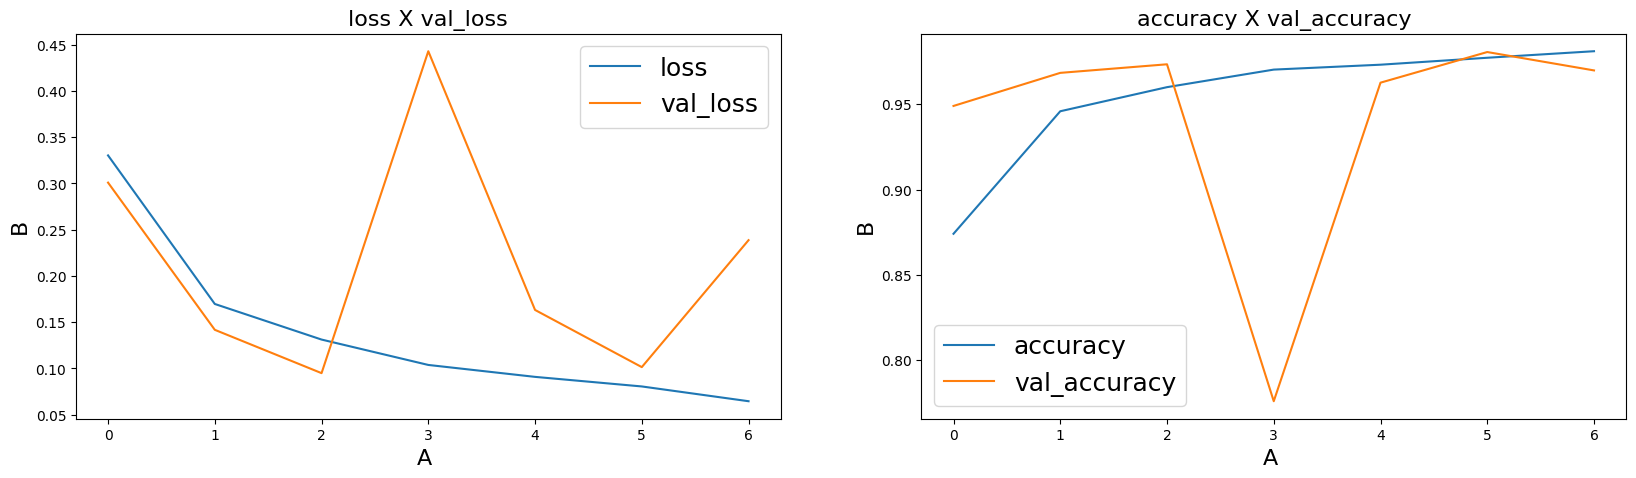

In [35]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [36]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
metrics.confusion_matrix(y_test, y_preds)

44/44 [==============================] - 3s 45ms/step


array([[1204,    2],
       [  40,  147]])

# **BERT**

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [38]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [39]:
texts = df['message_clean']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):

    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [41]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [42]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 60, 76                                           
                             8),                                                              

In [43]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2,
    epochs=3,
    batch_size=10
)

Epoch 1/3
446/446 [==============================] - 4160s 9s/step - loss: 0.4680 - accuracy: 0.8562 - val_loss: 0.3909 - val_accuracy: 0.8700
Epoch 2/3
446/446 [==============================] - 4222s 9s/step - loss: 0.4241 - accuracy: 0.8649 - val_loss: 0.3879 - val_accuracy: 0.8700
Epoch 3/3
446/446 [==============================] - 4180s 9s/step - loss: 0.4231 - accuracy: 0.8649 - val_loss: 0.3865 - val_accuracy: 0.8700


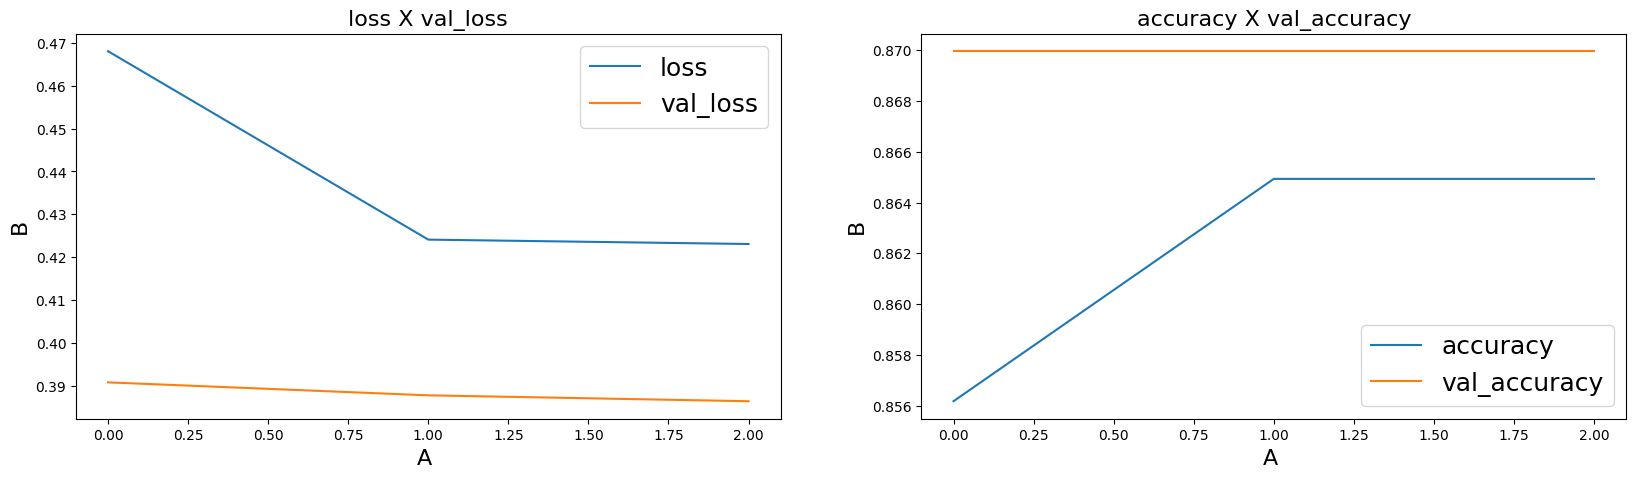

In [44]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
